In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
from sklearn import metrics

# Dataset and analysis

In [3]:
#The labelled portion of our dataset has labels 0, 1, 2 for the three levels of empathy (no, weak, strong)

data = pd.read_csv('/home/wanhee/SATbot2.0/model/EmpathyResponse/Lisa_EmpathyResponse.csv', encoding="utf-8")#put data in Drive root folder or change path
len(data)

1117

In [ ]:
data.head()

,response,zh_label
0,當你選擇了要嘗試的練習後，請開始該練習。完成後，你可以按“繼續”繼續。,2
1,你有什麼事嗎？,0
2,感謝你的參與，我真的很感激，你的努力非常寶貴。祝你有美好的一天！,2
3,我很感謝你的參與。我希望很快能再次與你合作。,2
4,感謝你如此開放，我正在嘗試確定提供幫助的最佳方式，並了解重新審視創傷是多麼困難。我想知道練習...,2


In [ ]:
#We consider the overall empathy_score (derived from the individual scores given by the 3 annotators).
#The classes in this dataset are approximately balanced
data.groupby('zh_label').size()

zh_label
0    331
1    388
2    381
dtype: int64

# Downsample

In [286]:
print(data)

                                               response  zh_label
0                   當你選擇了要嘗試的練習後，請開始該練習。完成後，你可以按“繼續”繼續。         2
1                                               你有什麼事嗎？         0
2                      感謝你的參與，我真的很感激，你的努力非常寶貴。祝你有美好的一天！         2
3                                我很感謝你的參與。我希望很快能再次與你合作。         2
4     感謝你如此開放，我正在嘗試確定提供幫助的最佳方式，並了解重新審視創傷是多麼困難。我想知道練習...         2
...                                                 ...       ...
1095                                    這個練習讓你感覺更好還是更糟？         0
1096                   太棒了，總是很高興聽到。你想讓我給你一個練習來感受更多的內容嗎？         1
1097                                如果出現任何問題，你是否總是批評自己？         0
1098                                       你覺得你讓某人失望了嗎？         0
1099                                           你想試試哪一個？         0

[1100 rows x 2 columns]


<AxesSubplot:>

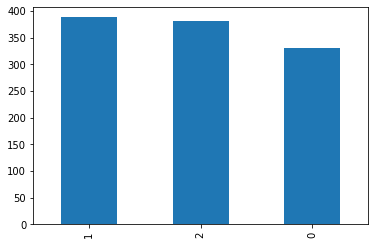

In [287]:
#checking the label distribution reveals the dataset is unbalanced
data.zh_label.value_counts().plot.bar()

In [114]:
#we downsample the majority classes to match the minority class ('fear') and obtain a more equal split of emotion labels

#separate the majority and minority classes
# If have bug, check the zh_label
df_minority  = data[data['zh_label']==0]
df_majority1 = data[data['zh_label']==2]
df_majority2 = data[data['zh_label']==1]

print(df_minority, df_majority1, df_majority2)

#downsample majority labels equal to the number of samples in the minority class
df_majority1 = df_majority1.sample(len(df_minority), random_state=0)
df_majority2 = df_majority2.sample(len(df_minority), random_state=0)

#concat the majority and minority dataframes
df_new = pd.concat([df_majority1, df_majority2, df_minority])

#shuffle the dataset
df_new = df_new.sample(frac=1, random_state=0)

                                             Unnamed: 0  \
1                          Did something happen to you?   
9     Give it a go now, please. When you're done, ju...   
11        Was this recent or did it happen in the past?   
13                  Was this caused by a certain event?   
18    When something goes wrong, do you always give ...   
...                                                 ...   
2193  Was this caused by a recent or distant event (...   
2194  Have you recently attempted Protocol 6 and as ...   
2195   Has this protocol made you feel better or worse?   
2197  Do you always criticise yourself if something ...   
2198                    Feel you have let someone down?   

                          response  zh_label  empathy_score  annotator1_score  \
1                          你有什麼事嗎？         0              0               0.0   
9             請現在試一試。完成後，只需點擊“繼續”。         0              0               0.0   
11                 這是最近發生的還是過去發生的？         0    

In [115]:
print(df_new)

                                             Unnamed: 0  \
1141  Are you telling me that you are having anxious...   
7     Thank you. As a result of your current emotion...   
1964  Is it maybe something that happened in the pas...   
2022  Ok, thanks, let's see if we can get to the bot...   
1299  Did you try using Protocol 11 and if so, why d...   
...                                                 ...   
1534  Was this event of recent event or was it more ...   
1555  In order to try to make you feel better, I nee...   
1081  Would you honestly say that you are open to ot...   
1825  There are a number of protocols we can try. Wh...   
1765  Thank you for your time - I am sure that we'll...   

                                         response  zh_label  empathy_score  \
1141        你是說你有焦慮的感覺，不知道你是否也記得你對另一個人是否有其他強烈的感情？         1              2   
7                       謝謝你。由於你當前的情緒，你是否覺得需要控制他人？         2              2   
1964            是否可能是過去幾天發生的事情導致了這種焦慮，或者感覺比感覺更遙遠？        

<AxesSubplot:>

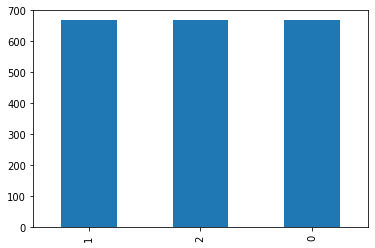

In [116]:
#check the distribution again, now it's balanced
df_new.zh_label.value_counts().plot.bar()

In [127]:
#get subsample of 20k samples for fine tuning
data = df_new.sample(n=1950)

#reset index
data.reset_index(drop=True, inplace=True)

In [128]:
len(data)

1950

In [288]:
#We replace the numerical labels with more meaningful string labels (useful to later use t5)
data["zh_label"].replace({0: "no", 1: "weak", 2: "strong"}, inplace=True)

In [289]:
#sanity check
data.head()

,response,zh_label
0,當你選擇了要嘗試的練習後，請開始該練習。完成後，你可以按“繼續”繼續。,strong
1,你有什麼事嗎？,no
2,感謝你的參與，我真的很感激，你的努力非常寶貴。祝你有美好的一天！,strong
3,我很感謝你的參與。我希望很快能再次與你合作。,strong
4,感謝你如此開放，我正在嘗試確定提供幫助的最佳方式，並了解重新審視創傷是多麼困難。我想知道練習...,strong


In [290]:
#generate the text files for your train, val, and test datasets (we use an 85:5:10 split)

train_path = "/home/wanhee/SATbot2.0/model/EmpathyResponse/my_train.txt"
test_path = "/home/wanhee/SATbot2.0/model/EmpathyResponse//my_test.txt"
val_path = "/home/wanhee/SATbot2.0/model/EmpathyResponse//my_val.txt"


from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 85-15 split
input_train, input_val, target_train, target_val = train_test_split(data.response.to_numpy(), 
                                                                    data.zh_label.to_numpy(), 
                                                                    test_size=0.15, random_state=17)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 67:33
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.67, random_state=17)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

#and write them to file
train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

In [291]:
#we will use the concatenated train and validation test to fit our logistic regression function
train_val = pd.concat([train_dataset, val_dataset])

In [292]:

train_val.head()

,text,class
0,非常感謝你參加本次會議，非常感謝你的時間和你提供的深思熟慮的意見，並希望本次會議對你有所幫助...,strong
1,我很遺憾聽到這個消息。你想嘗試不同的練習，看看它是否效果更好？,strong
2,你認為你應該為別人犧牲自己嗎？,no
3,當你被激怒時，你是否經常發現自己試圖控制別人？,no
4,你覺得你在日常生活中與你身邊的人有麻煩嗎？,no


c:\Users\Wan Hee\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


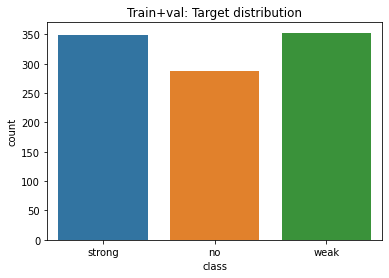

In [293]:

#visualise label distribution
sn.countplot(train_val['class']);
plt.title('Train+val: Target distribution');

In [294]:
text_transformer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, max_features=150000)


In [295]:
X_train_text = text_transformer.fit_transform(train_val['text'])
X_test_text = text_transformer.transform(test_dataset['text'])

In [296]:
print(X_train_text.shape, 
      X_test_text.shape)

(989, 3008) (111, 3008)


In [297]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)


In [298]:
logit.fit(X_train_text, train_val['class'])


LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=4, random_state=17)

In [299]:
test_preds = logit.predict(X_test_text)


In [300]:

test_preds = logit.predict(X_test_text)

In [301]:

y_pred = pd.DataFrame(test_preds, columns=['class'])
y_pred.head()

,class
0,no
1,strong
2,strong
3,weak
4,strong


In [302]:
#check accuracy, we get ~60% on train+val set
outputs = y_pred['class'].to_numpy().tolist()
targets = test_dataset['class'].to_numpy().tolist()

metrics.accuracy_score(targets, outputs).round(4)

0.4685

In [303]:
#check all metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.6923    0.2045    0.3158        44
      strong     0.5714    0.6250    0.5970        32
        weak     0.3651    0.6571    0.4694        35

    accuracy                         0.4685       111
   macro avg     0.5429    0.4956    0.4607       111
weighted avg     0.5543    0.4685    0.4453       111



In [304]:

cm = metrics.confusion_matrix(targets, outputs)

<AxesSubplot:>

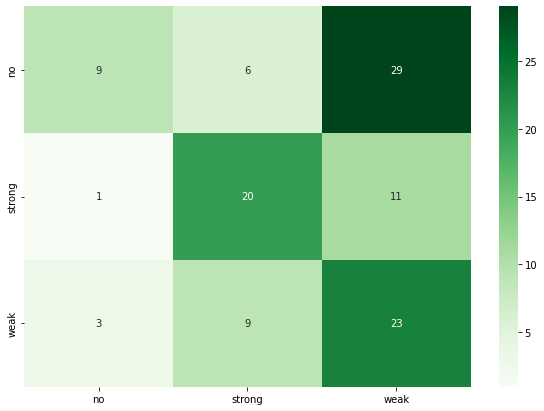

In [305]:

df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')